# AdaBoost

AdaBoost is short for adaptive boosting. AdaBoost trains a series of weak learners, with each subsequent classifier paying more attention to the training instances that were misclassified by its predecessors.

## What we will accomplish

In this notebook we will:
- Show how AdaBoost works,
- Demonstrate how to implement AdaBoost in `sklearn` and
- Provide references for you to learn more about AdaBoost.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")

## How it works

AdaBoost (short for adaptive boosting) is an algorithm that builds a, hopefully, strong learner with an iterative sequence of weak learners.

The first weak learner is trained on the training data normally. For weak learner $j$, the weights on each training sample are determined by the performance by weak learner $j-1$. After training $W$ total weak learners a final prediction is made by performing a weighted vote among all $W$ weak learners, with voting weight determined by the learner's accuracy (in the case of classification).

Let's explicitly set this up now, then we will demonstrate the process with a toy example. For this example we will be working with a classification problem.

Let $y^{(i)}$ denote the class of observation $i$, $\hat{y}^{(i)}_j$ the prediction on observation $i$ of weak learner $j$ and $w^{(i)}$ the current weight assigned to observation $i$.

After the $j^{\text{th}}$ weak learner is trained, that learner's <i>weighted error rate</i> is calculated:

$$
r_j = \frac{\sum_{i=1}^n w^{(i)} 1_{\{ \hat{y}^{(i)}_j \neq y^{(i)}\}} }{\sum_{i=1}^n w^{(i)}} = 1 -  \text{weighted accuracy}.
$$

$r_j$ is large precisely when the $j^\text{th}$ weak learner is bad and $r_j$ is small when the $j^\text{th}$ weak learner is good. The next step is to compute the weight assigned to the weak learner itself:

$$
\alpha_j = \eta \log \left( \frac{1-r_j}{r_j} \right),
$$

where $\eta$ is the <i>learning rate</i> of the algorithm, a hyperparameter you must set prior to fitting the algorithm. Notice that $\alpha_j$ is small when $r_j$ is large (a bad weak learner) and large when $r_j$ is small (a good weak learner). Finally we update the training sample weights for weak learner $j+1$:

$$
w^{(i)} \leftarrow \left\lbrace \begin{array}{l c}w^{(i)} & \text{if } \hat{y}^{(i)}_j = y^{(i)} \\
                                    w^{(i)} \exp(\alpha_j) & \text{if } \hat{y}^{(i)}_j \neq y^{(i)}\end{array}\right.,
$$

which will increase the weight on incorrectly predicted samples (assuming $\alpha_j > 0$).

#### A toy example

Let's demonstrate what's going on with AdaBoost using a toy example, let's say I want to train an AdaBoost classifier on these data:

<img src="ensemble1.png" width = "60%"></img>

For the first weak learner each observation is given a uniform weight $w_i = \frac{1}{6}$, $i=1,\dots,6$. Let's say that this first weak learner gives a decision rule like so:

<img src="ensemble2.png" width = "60%"></img>

AdaBoost would now calculate in order, $r_1$, $\alpha_1$ and then the new weights, for simplicity let's take $\eta=1$ as our learning rate.

$$
r_1 = \frac{0 + 0 + 1/6 + 0 + 0 + 0}{1/6 + 1/6 + 1/6 + 1/6 + 1/6 + 1/6} = \frac{1}{6},
$$

<br>
<br>

$$
\alpha_1 = \log\left(\frac{1-1/6}{1/6}\right) =  \log(5)
$$

<br>
<br>

$$
w^{(1)} \leftarrow \frac{1}{6},
$$

$$
w^{(2)} \leftarrow \frac{1}{6},
$$

$$
w^{(3)} \leftarrow \frac{1}{6} \exp\left( \log(5) \right) = \frac{5}{6},
$$

$$
w^{(4)} \leftarrow \frac{1}{6},
$$

$$
w^{(5)} \leftarrow \frac{1}{6},
$$

$$
w^{(6)} \leftarrow \frac{1}{6}.
$$

These new weights are then used in training the second weak learner which, due to the increased weight on observation $3$, would produce a new decision boundary:

<img src="ensemble3.png" width = "60%"></img>

We now calculate $r_2$, $\alpha_2$ and update the weights.

$$
r_2 = \frac{0 + 0 + 0 + 1/6 + 0 + 0}{1/6 + 1/6 + 5/6 + 1/6 + 1/6 + 1/6} = \frac{1}{10},
$$

<br>
<br>

$$
\alpha_2 = \log\left( \frac{1-1/10}{1/10} \right) = \log(9)
$$

<br>
<br>

$$
w^{(1)} \leftarrow \frac{1}{6},
$$

$$
w^{(2)} \leftarrow \frac{1}{6},
$$

$$
w^{(3)} \leftarrow \frac{5}{6},
$$

$$
w^{(4)} \leftarrow \frac{1}{6} \exp\left( \log(9) \right) = \frac{3}{2},
$$

$$
w^{(5)} \leftarrow \frac{1}{6},
$$

$$
w^{(6)} \leftarrow \frac{1}{6}.
$$


If we were to stop here predictions would be made using a weighted vote where weak learner 1 gets a vote worth $\log(5)$ and weak learner 2 get a vote worth $\log(9)$.

## In `sklearn`

Let's now demonstrate how to implement this algorithm as a classifier in `sklearn` with `AdaBoostClassifier`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html">https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html</a>. <i>For an adaptive boosting regression model check out `AdaBoostRegressor`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html">https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html</a>.</i>

In [2]:
np.random.seed(888)

X = np.zeros((25,2))
X[:,0] = np.random.random(25)
X[:,1] = np.random.random(25)

y = np.zeros(25)
y[X[:,0]-X[:,1]>=0] = 1

## for predictions
xx1, xx2 = np.meshgrid(np.arange(-.01, 1.01, .01),
                          np.arange(-.01, 1.01, .01))

X_pred = np.zeros((len(xx1.reshape(-1,1)), 2))
X_pred[:,0] = xx1.flatten()
X_pred[:,1] = xx2.flatten()

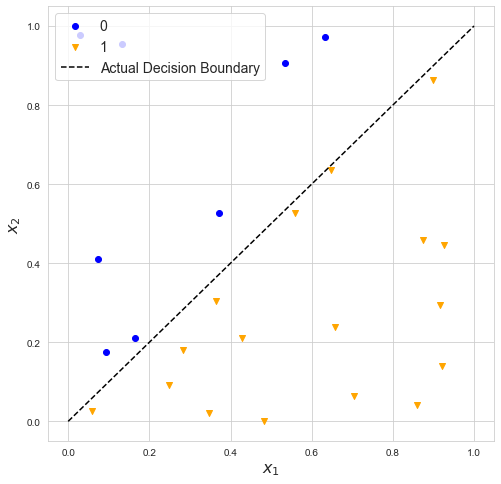

In [3]:
plt.figure(figsize = (8,8))
plt.scatter(X[y == 0,0], 
            X[y == 0,1],
            c='blue',
            label="0")
plt.scatter(X[y == 1,0], 
            X[y == 1,1],
            c='orange',
            marker='v',
            label="1")


plt.plot([0,1],
         [0,1],
         'k--',
         label="Actual Decision Boundary")


plt.xlabel("$x_1$",fontsize = 16)
plt.ylabel("$x_2$",fontsize = 16)
plt.legend(fontsize='14', loc=2)

plt.show()

For our weak learner we will use a decision stump.

In [4]:
## Import AdaBoost
from sklearn.ensemble import AdaBoostClassifier


## Import the base classifier
from sklearn.tree import DecisionTreeClassifier

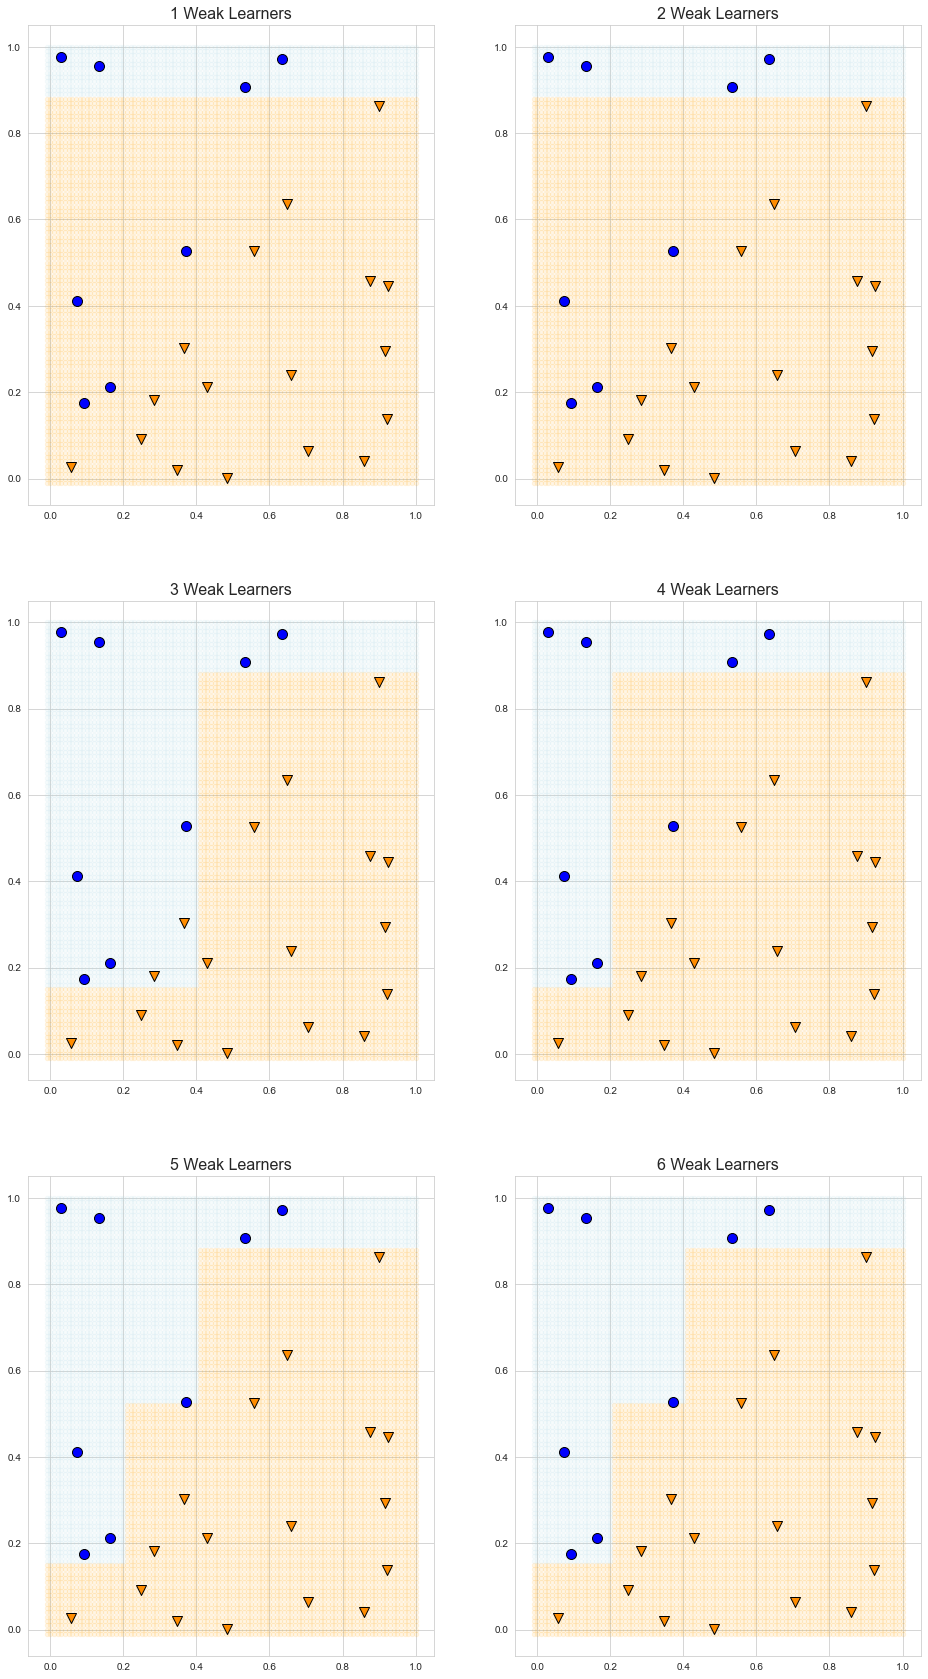

In [5]:
fig,ax = plt.subplots(3,2, figsize=(16,30))

j = 0
for i in range(1,7):
    # n_estimators controls how many weak learners we use
    # learning_rate is a hyperparameter that controls how
    # aggressively we correct incorrect labels
    # algorithm is the algorithm that sklearn runs to fit the model
    # SAMME.R or SAMME are the options, SAMME.R allows calculation
    # of probabilities.
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                    n_estimators=i,
                                    algorithm = 'SAMME.R',
                                    random_state=123)
    
    # fit the classifier
    ada_clf.fit(X, y)
    
    # make some predictions
    preds = ada_clf.predict(X_pred)
    
    
    ## this plots the resulting decision boundary ##
    ax[j//2,j%2].scatter(X_pred[preds==1,0],
                X_pred[preds==1,1],
                alpha=.1,
                c='orange',
                s=20)
    ax[j//2,j%2].scatter(X_pred[preds==0,0],
                X_pred[preds==0,1],
                alpha=.1,
                c='lightblue',
                s=20)
    
    ax[j//2,j%2].scatter(X[y == 1,0],
                         X[y == 1,1],
                         s=100,
                         c = "darkorange",
                         marker = 'v',
                         label="Training 1", 
                         edgecolor='black')
    ax[j//2,j%2].scatter(X[y == 0,0],
                         X[y == 0,1],
                         s=100,
                         c = "blue",
                         label="Training 0", 
                         edgecolor='black')
    
    ax[j//2,j%2].set_title(str(i) + " Weak Learners", fontsize=16)

    
    j = j+1


plt.show()

As you might notice when we increase the number of weak learners we use in the model we tend to overfit to training data. One way to control for this is to not use too many estimators. Where as always the correct number of estimators depends on the data you are fitting.

### References

Some additional references on AdaBoost models can be found below:


<a href = "http://rob.schapire.net/papers/Schapire99c.pdf">A Brief Introduction to Boosting</a> by Robert E. Schapire

<a href = "https://mitpress.mit.edu/books/boosting">Boosting</a> by  Robert E. Schapire and Yoav Freund

<a href = "https://www.csie.ntu.edu.tw/~mhyang/course/u0030/papers/schapire.pdf">A Boosting Tutorial</a> by Robert E.  Schapire

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)